In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.4f}'.format

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

Objective: Apriori function to extract frequent itemsets for association rule mining

Text and code from: http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

In [2]:
df=pd.read_csv('./MAPdata/SHR76_19.csv')
#df=df.replace('Unknown', np.nan)

In [3]:
#Display columns in list
list(df.columns)

['ID',
 'CNTYFIPS',
 'Ori',
 'State',
 'Agency',
 'Agentype',
 'Source',
 'Solved',
 'Year',
 'StateName',
 'Month',
 'Incident',
 'ActionType',
 'Homicide',
 'Situation',
 'VicAge',
 'VicSex',
 'VicRace',
 'VicEthnic',
 'OffAge',
 'OffSex',
 'OffRace',
 'OffEthnic',
 'Weapon',
 'Relationship',
 'Circumstance',
 'Subcircum',
 'VicCount',
 'OffCount',
 'FileDate',
 'MSA']

In [4]:
print('Number of rows in dataframe',len(df))

Number of rows in dataframe 804751


In [5]:
print('Number of rows per state')
df.State.value_counts()

Number of rows per state


California              120462
Texas                    77226
New York                 59516
Florida                  45970
Michigan                 35326
Illinois                 35298
Pennsylvania             30898
Georgia                  26515
North Carolina           25666
Ohio                     25197
Louisiana                24992
Maryland                 21449
Virginia                 19784
Missouri                 19723
Tennessee                19188
New Jersey               17550
Alabama                  16772
Arizona                  15841
South Carolina           15303
Indiana                  14654
Oklahoma                 11184
Washington                9635
Kentucky                  9307
Arkansas                  8860
District of Columbia      8673
Colorado                  8497
Mississippi               8215
Wisconsin                 8050
Massachusetts             7538
Nevada                    7112
Connecticut               5864
New Mexico                5417
Oregon  

In [6]:
print('Distribution of Victims')
df['VicRaceSex']=df['VicRace']+' '+df['VicSex']
df.VicRaceSex.value_counts(normalize=True)

Distribution of Victims


Black Male                                   0.3911
White Male                                   0.3603
White Female                                 0.1337
Black Female                                 0.0815
Asian Male                                   0.0100
Unknown Male                                 0.0073
American Indian or Alaskan Native Male       0.0055
Asian Female                                 0.0044
Unknown Female                               0.0023
American Indian or Alaskan Native Female     0.0020
Unknown Unknown                              0.0015
White Unknown                                0.0001
Native Hawaiian or Pacific Islander Male     0.0001
Black Unknown                                0.0001
Native Hawaiian or Pacific Islander Female   0.0000
Asian Unknown                                0.0000
American Indian or Alaskan Native Unknown    0.0000
Name: VicRaceSex, dtype: float64

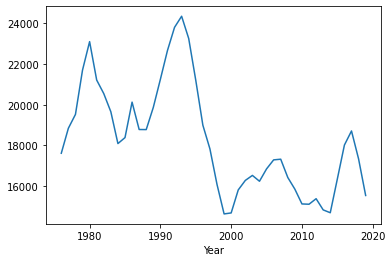

In [7]:
df.groupby(df['Year']).size().plot()

Time for the Frequent Itemset

In [8]:
#only interested in cases since 2000
df2000=df[df['Year']>=2000]
#Generating a unique Frequent Itemset number based upon the geography (either county or metropolitan area), victims' gender and method of killing.
dfsub=df2000[['State','CNTYFIPS',"MSA",'VicSex','VicRace','Weapon']]
dfsub_list = dfsub.to_numpy()
dfsub.head()


,State,CNTYFIPS,MSA,VicSex,VicRace,Weapon
446,Alaska,"Anchorage, AK","Anchorage, AK",Female,Black,"Handgun - pistol, revolver, etc"
447,Alaska,"Anchorage, AK","Anchorage, AK",Female,White,"Handgun - pistol, revolver, etc"
448,Alaska,"Anchorage, AK","Anchorage, AK",Male,Asian,"Personal weapons, includes beating"
449,Alaska,"Anchorage, AK","Anchorage, AK",Male,Asian,"Personal weapons, includes beating"
450,Alaska,"Anchorage, AK","Anchorage, AK",Female,American Indian or Alaskan Native,Knife or cutting instrument


Text and code from: http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

Apriori is a popular algorithm for extracting frequent itemsets with applications in association rule learning. An itemset is considered as "frequent" if it meets a user-specified support threshold. For instance, if the support threshold is set to 0.5 (50%), a frequent itemset is defined as a set of items that occur together in at least 50% of all transactions in the database.

The apriori function expects data in a one-hot encoded pandas DataFrame. Suppose we have the following transaction data:

In [9]:
te = TransactionEncoder()
te_ary = te.fit(dfsub_list).transform(dfsub_list)
dfsubte = pd.DataFrame(te_ary, columns=te.columns_)

In [10]:
frequent_itemsets = apriori(dfsubte, min_support=0.4, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.4912,(Black),1
1,0.4833,"(Handgun - pistol, revolver, etc)",1
2,0.7815,(Male),1
3,0.4701,(White),1
4,0.4180,"(Black, Male)",2
5,0.4109,"(Male, Handgun - pistol, revolver, etc)",2


The advantage of working with pandas DataFrames is that we can use its convenient features to filter the results. For instance, let's assume we are only interested in itemsets of length 2 that have a support of at least 80 percent. First, we create the frequent itemsets via apriori and add a new column that stores the length of each itemset.Then, we can select the results that satisfy our desired criteria as follows:

In [11]:
#I am interested in 3 or more similar cases out of the 804751 cases, so the threshold is 3/804751
custom_thres=3/len(df2000)

#Although this takes a very long time to run, I would recommend either increasing the threshold,
#or by reducing the dataframe size. You can do this by subselecting the state/region
#or by only looking at solved or solved cases

In [ ]:
# I am interested in cases are similiar in state, county/metro, victim race and weapon used, so I'm interested in 
# a variable that has a length of at least 4

custom_length=4
frequent_itemsets = apriori(dfsubte, min_support=custom_thres, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets[ (frequent_itemsets['length']>=custom_length)]


In [ ]:
#If you are interested in specific variables
frequent_itemsets[ frequent_itemsets['itemsets'] == {'Black', 'Male'} ]